<a href="https://colab.research.google.com/github/sudeepmenon17/PytorchforNN/blob/main/AirfoilS809_SAmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
!pip install google-auth

In [85]:
from google.colab import auth
from google.colab import drive

In [86]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
# !ls /content/drive/MyDrive/


In [88]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
# Create a Model class
class Model(nn.Module):
  def __init__(self,in_features=6, h1 = 61, h2 = 60, out_features=1):
    super().__init__()
    self.fc1 = nn.Linear(in_features,h1)
    self.dropout1 = nn.Dropout(0.25)
    self.fc2 = nn.Linear(h1,h2)
    self.dropout2 = nn.Dropout(0.15)
    # self.fc3 = nn.Linear(h2,h3)
    # self.dropout3 = nn.Dropout(0.25)
    self.out = nn.Linear(h2,out_features)

  def forward(self,x):
    x = F.sigmoid(self.fc1(x))
    x = self.dropout1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.dropout2(x)
    # x = F.sigmoid(self.fc3(x))
    # x = self.dropout3(x)
    x = self.out(x)

    return x

In [90]:
torch.manual_seed(42)

model = Model()

In [91]:
# Read the data set -  Airfoil S809
df1 = pd.read_csv("/content/drive/MyDrive/data_set1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/data_set2.csv")
df3 = pd.read_csv("/content/drive/MyDrive/data_set3.csv")
df4 = pd.read_csv("/content/drive/MyDrive/data_set4.csv")


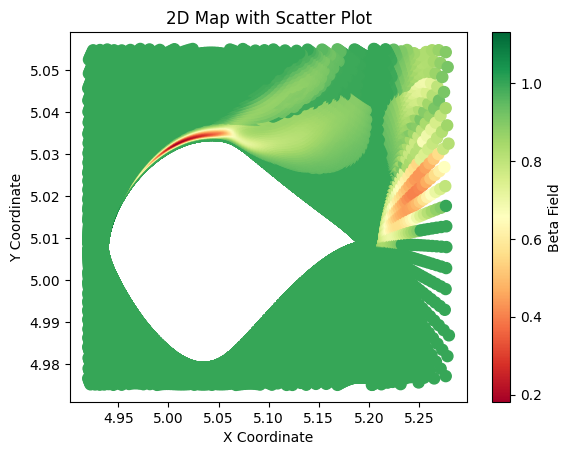

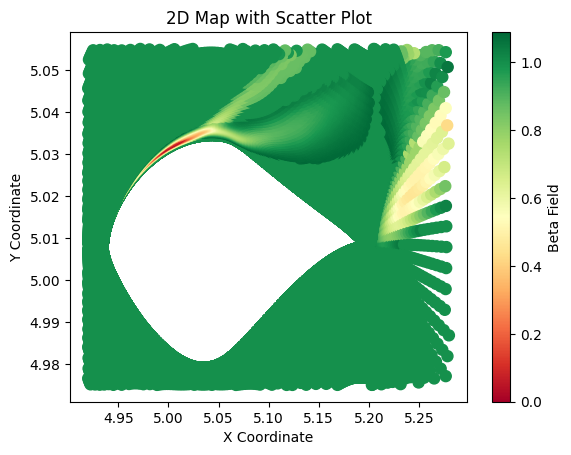

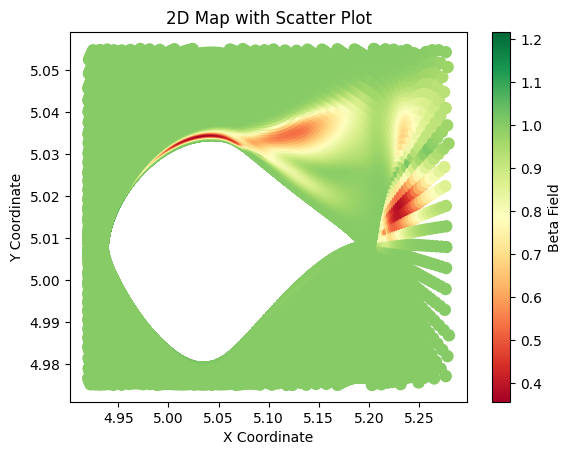

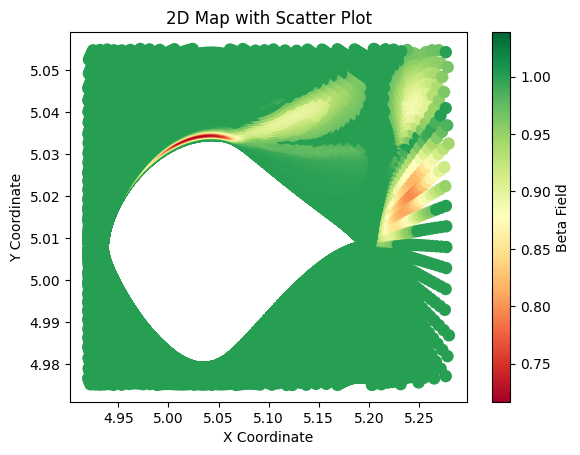

In [92]:
# Combine data
frames = [df1, df2, df3, df4]
ff = []

for item in frames:
  xc = np.array(item['x'])
  yc = np.array(item['y'])
  b = np.array(item['beta'])
  ff1 = np.array(item['feature1'])
  ff2 = np.array(item['feature2'])
  ff3 = np.array(item['feature3'])
  ff4 = np.array(item['feature4'])
  ff5 = np.array(item['feature5'])
  ff6 = np.array(item['feature6'])

  # Normalize x and y coordinates
  min_range = -5.0
  max_range = 5.0
  xc = (xc - np.min(xc)) * (max_range - min_range) / (np.max(xc) - np.min(xc))
  yc = (yc - np.min(yc)) * (max_range - min_range) / (np.max(yc) - np.min(yc))


  # #####################################################################
  # # Cleaning the beta field in the wake region
  # for k in range(len(xc)):
  #   if xc[k] >= 5.2 and xc[k] <= 5.3:
  #     if yc[k] >= 5.00 and yc[k] <= 4.96:
  #       b2.append(b[k])

  # for j in range(len(xc)):
  #   if xc[j] > 5.15 or yc[j]>5.04:
  #     b[j] = np.mean(b2)

  x1,y1,b1,f1,f2,f3,f4,f5,f6 = [[] for i in range(9)]
  # Filter data for the specified range of coordinates
  for i in range(len(xc)):
    if xc[i]>=4.92 and xc[i]<=5.28:
      if yc[i]>=4.975 and yc[i]<=5.055:
        x1.append(xc[i])
        y1.append(yc[i])
        b1.append(b[i])
        f1.append(ff1[i])  # /1600 - 0.5
        f2.append(ff2[i])  # /4200 - 0.5
        f3.append(ff3[i])  # /370000000 - 0.5
        f4.append(ff4[i])  # /10200 - 0.5
        f5.append(ff5[i])  # /30000 - 0.5
        f6.append(ff6[i])  # /1.2 - 0.5

  modified_data = {
  'x': np.array(x1),
  'y': np.array(y1),
  'beta': np.array(b1),
  'feature1': np.array(f1),
  'feature2': np.array(f2),
  'feature3': np.array(f3),
  'feature4': np.array(f4),
  'feature5': np.array(f5),
  'feature6': np.array(f6)
  }


  ff.append(pd.DataFrame(modified_data))

  # # #####################################################################
  # # Plotting cleaned data
  # ################################
  # nx = []
  # ny = []
  # nb = []


  # # Filter data for the specified range of coordinates
  # for i in range(len(xc)):
  #   if xc[i]>=4.9 and xc[i]<=5.3:
  #     if yc[i]>=4.925 and yc[i]<=5.075:
  #       nx.append(xc[i])
  #       ny.append(yc[i])
  #       nb.append(b[i])

  # Create a scatter plot
  plt.scatter(x1, y1, c=b1,  cmap= 'RdYlGn',alpha=1, marker='.',s=250)
  plt.colorbar(label='Beta Field')
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.title('2D Map with Scatter Plot')
  plt.show()
###############################################################################

df = pd.concat(ff)


# Data for beta>1.02 or beta<0.98
df_filtered = df[(df['beta'] < 0.995) | (df['beta'] > 1.005)]

# df_filtered = df[df['beta'] != 1.0]

# df_filtered = df



<Axes: xlabel='feature3', ylabel='Density'>

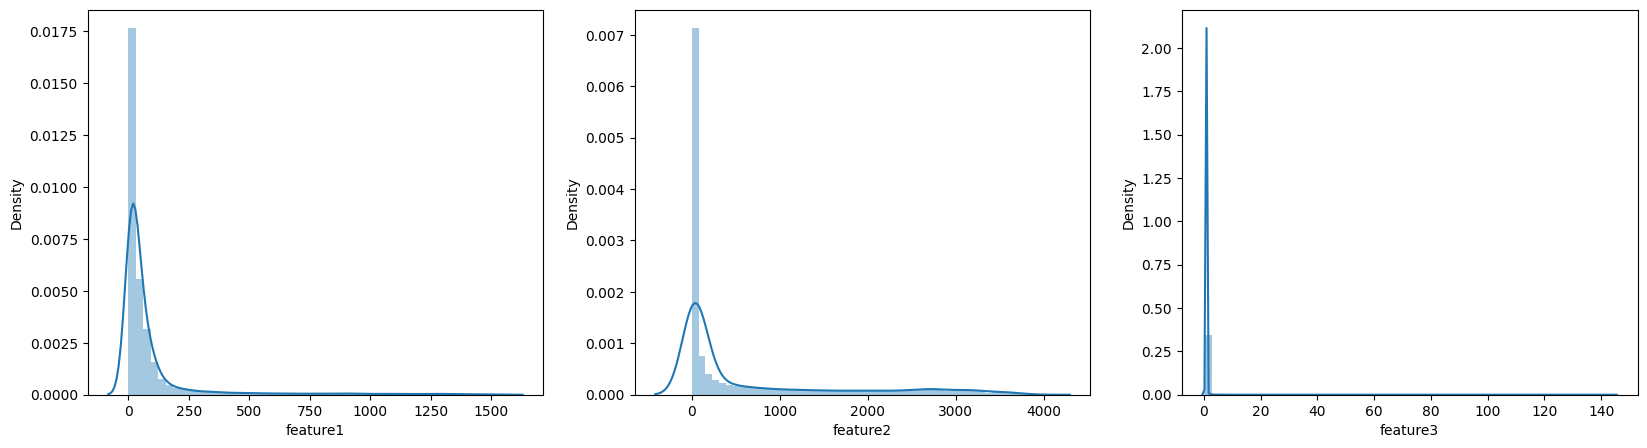

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')




# Preprocess Features
df1 = df_filtered.drop(['x','y','beta'],axis=1)
df2 = df_filtered.drop(['x','y','feature1','feature2','feature3','feature4','feature5','feature6'],axis=1)



## Features with a few outliers and very large range are --> 3,4 and 5
# df1 = df1[df1['feature2'] < 100]
# df1 = df1[df1['feature3'] < 100.0]
# df1 = df1[(df1['feature5'] > 0) & (df1['feature5'] < 60000.0)]

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(df1['feature1'])
plt.subplot(1,3,2)
sns.distplot(df1['feature2'])
plt.subplot(1,3,3)
sns.distplot(df1['feature3'])



<Axes: xlabel='feature6', ylabel='Density'>

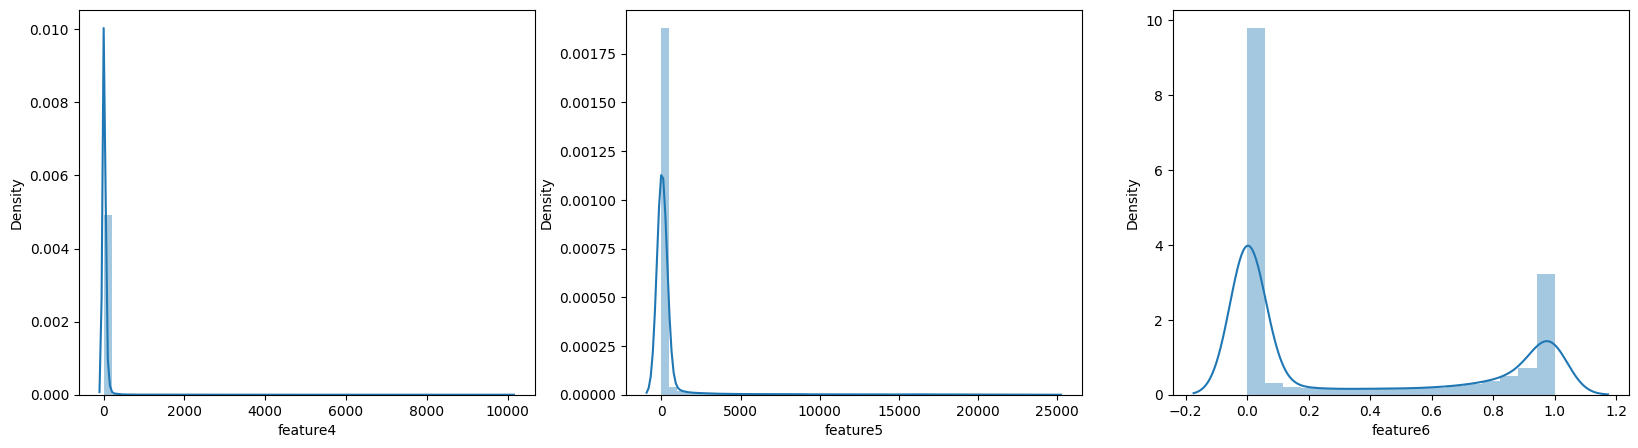

In [94]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(df1['feature4'])
plt.subplot(1,3,2)
sns.distplot(df1['feature5'])
plt.subplot(1,3,3)
sns.distplot(df1['feature6'])

In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler





# Fill missing values with the mean
df1 = df1.fillna(df1.mean())
# m = df1.max()
# df1 = df1.div(m)

df1.min(),df1.max()

(feature1    0.016143
 feature2    1.097497
 feature3    0.012101
 feature4    0.001637
 feature5    0.000731
 feature6    0.000000
 dtype: float64,
 feature1     1547.650392
 feature2     3879.514819
 feature3      145.017526
 feature4    10058.096230
 feature5    24298.278480
 feature6        0.999971
 dtype: float64)

In [96]:

# Standardization
# standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler(feature_range=(0, 10000))
# transformer = Normalizer()
scaler = RobustScaler(with_centering=False)

# Features
# X = min_max_scaler.fit_transform(df1)
X = df1.values

# # Target
# # y = df_filtered['beta'].values
# # y = standard_scaler.fit_transform(df2)
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
# y = min_max_scaler.fit_transform(df2)
# # y = scaler.fit_transform(df2)
y = df2.values

In [97]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001,weight_decay=0.0000001)
# optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,weight_decay=0.0)

In [98]:
#5-Fold Cross Validation
from sklearn import metrics

from sklearn.model_selection import KFold
kFold=KFold(n_splits=5,shuffle=True, random_state=100)

# Initialize a list to store the evaluation scores
scores = []
training_cost = []
testing_cost =[]
iterations = 2500
train_fold = [[] for i in range(5)]
test_fold = [[] for i in range(5)]
c = 0
for train_index,test_index in kFold.split(X):
  print("Train Index: ", train_index, "\n")
  print("Test Index: ", test_index)
  print("Size of training data:", len(train_index),"\n")
  print("Size of testing data:", len(test_index),"\n")

  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]


  X_train = torch.FloatTensor(X_train)
  X_test = torch.FloatTensor(X_test)

  y_train = torch.FloatTensor(y_train)
  y_test = torch.FloatTensor(y_test)


  losses = []
  for i in range(iterations):
    # go forward and predict
    y_pred = model.forward(X_train)

    # Measure the loss
    loss = criterion(y_pred,y_train)

    # Keep track of the losses
    losses.append(loss.detach().numpy())

    # print every 10 epoch
    if i % 10 == 0:
      print(f'iter: {i} and loss: {loss}')

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_fold[c].append(y_pred.detach().numpy())
  train_fold[c].append(y_train.detach().numpy())
  training_cost.append(losses)

  # Evaluate Model
  with torch.no_grad():
    y_eval = model.forward(X_test)
    test_loss = criterion(y_eval,y_test)
  test_fold[c].append(y_eval.detach().numpy())
  test_fold[c].append(y_test.detach().numpy())

  testing_cost.append(test_loss)
  scores.append(metrics.mean_squared_error(y_eval,y_test))
  print('MSEloss: {}'.format(testing_cost))
  print('MSE error: {}'.format(scores))

  c = c+1

Train Index:  [    0     1     3 ... 20713 20715 20716] 

Test Index:  [    2     7     8 ... 20703 20711 20714]
Size of training data: 16573 

Size of testing data: 4144 

iter: 0 and loss: 0.5927398800849915
iter: 10 and loss: 0.07917293161153793
iter: 20 and loss: 0.07099146395921707
iter: 30 and loss: 0.05707307532429695
iter: 40 and loss: 0.04650314152240753
iter: 50 and loss: 0.04653779789805412
iter: 60 and loss: 0.043631412088871
iter: 70 and loss: 0.04266166687011719
iter: 80 and loss: 0.040932975709438324
iter: 90 and loss: 0.0401327945291996
iter: 100 and loss: 0.03893359750509262
iter: 110 and loss: 0.03730772063136101
iter: 120 and loss: 0.03714551776647568
iter: 130 and loss: 0.03639299049973488
iter: 140 and loss: 0.03547360375523567
iter: 150 and loss: 0.03442167118191719
iter: 160 and loss: 0.03367733210325241
iter: 170 and loss: 0.0333295613527298
iter: 180 and loss: 0.03271900862455368
iter: 190 and loss: 0.032700520008802414
iter: 200 and loss: 0.03237137570977211
i

Text(0.5, 1.0, 'Fold5')

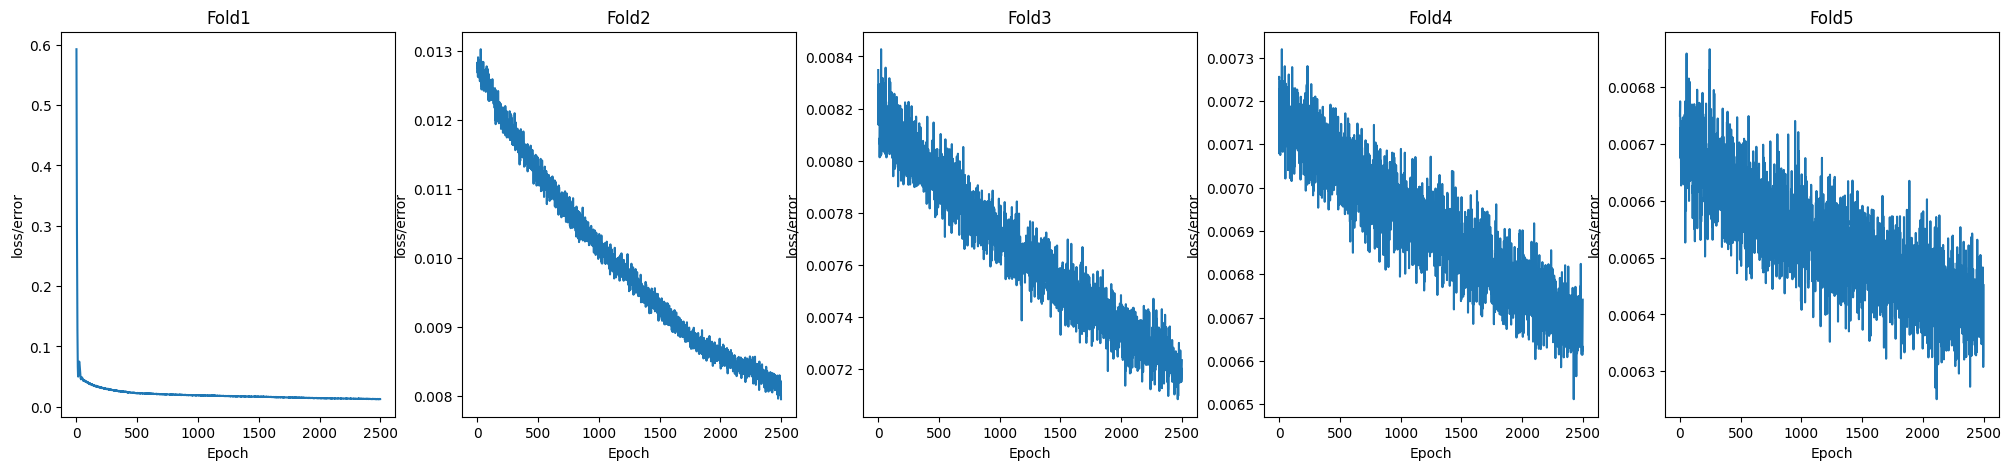

In [99]:
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.plot(range(iterations), training_cost[0])
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.title('Fold1')
plt.subplot(1,5,2)
plt.plot(range(iterations), training_cost[1])
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.title('Fold2')
plt.subplot(1,5,3)
plt.plot(range(iterations), training_cost[2])
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.title('Fold3')
plt.subplot(1,5,4)
plt.plot(range(iterations), training_cost[3])
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.title('Fold4')
plt.subplot(1,5,5)
plt.plot(range(iterations), training_cost[4])
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.title('Fold5')

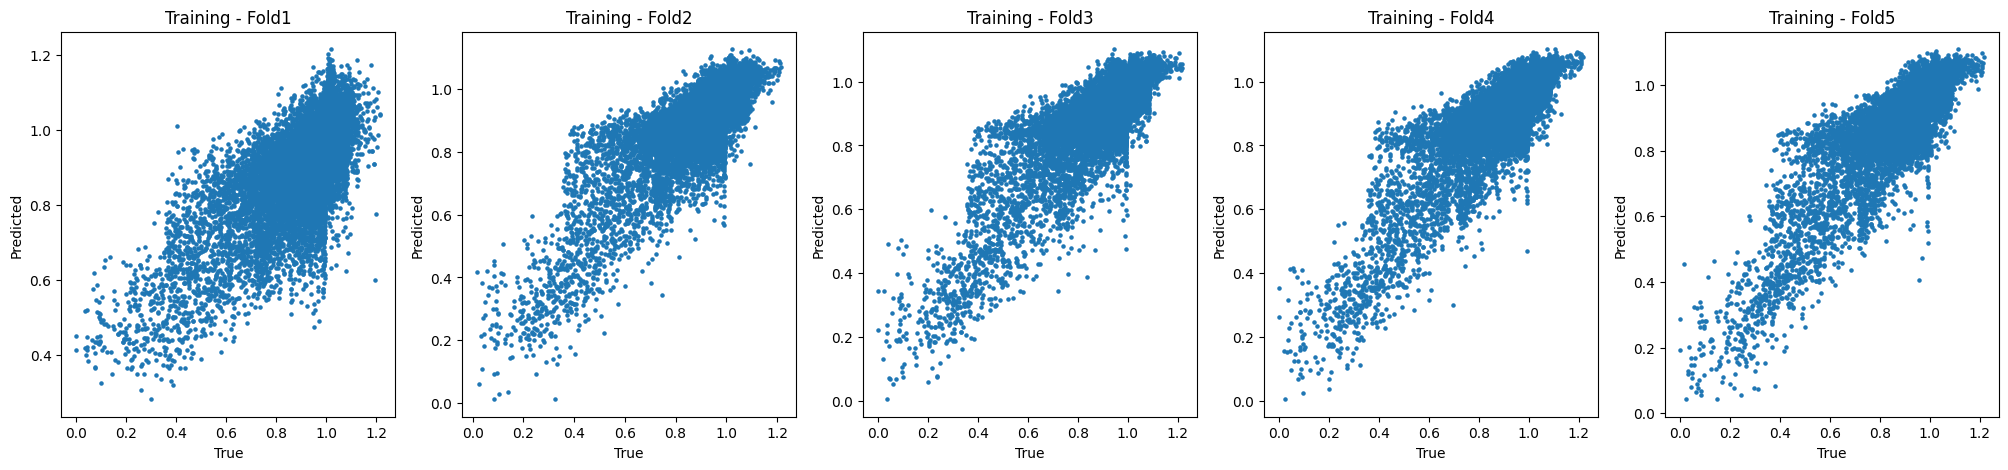

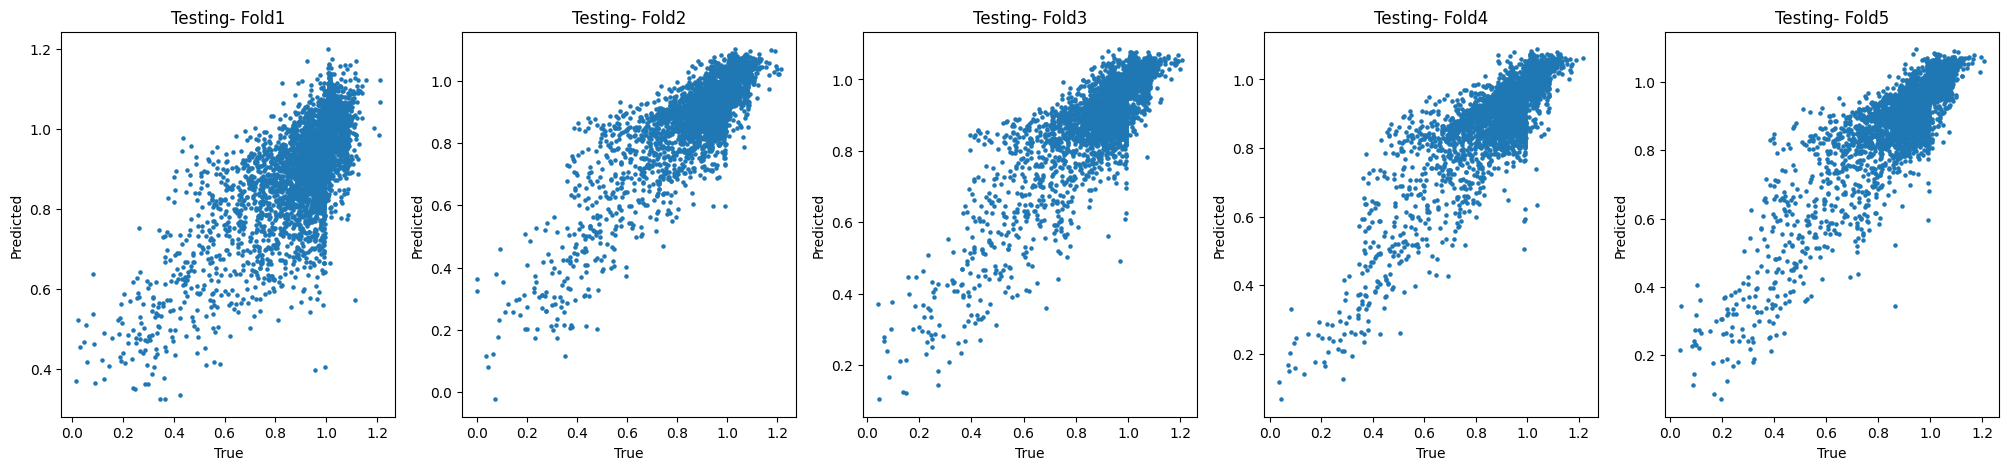

In [100]:
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.scatter(train_fold[0][1],train_fold[0][0], s=5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training - Fold1')
plt.subplot(1,5,2)
plt.scatter(train_fold[1][1],train_fold[1][0], s=5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training - Fold2')
plt.subplot(1,5,3)
plt.scatter(train_fold[2][1],train_fold[2][0], s=5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training - Fold3')
plt.subplot(1,5,4)
plt.scatter(train_fold[3][1],train_fold[3][0], s=5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training - Fold4')
plt.subplot(1,5,5)
plt.scatter(train_fold[4][1],train_fold[4][0], s=5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training - Fold5')
# plt.ylim(-4,2)

plt.show()

plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.scatter(test_fold[0][1],test_fold[0][0],s =5 )
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Testing- Fold1')
plt.subplot(1,5,2)
plt.scatter(test_fold[1][1],test_fold[1][0],s =5 )
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Testing- Fold2')
plt.subplot(1,5,3)
plt.scatter(test_fold[2][1],test_fold[2][0],s =5 )
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Testing- Fold3')
plt.subplot(1,5,4)
plt.scatter(test_fold[3][1],test_fold[3][0],s =5 )
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Testing- Fold4')
plt.subplot(1,5,5)
plt.scatter(test_fold[4][1],test_fold[4][0],s =5 )
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Testing- Fold5')


plt.show()

In [101]:
print(model)



Model(
  (fc1): Linear(in_features=6, out_features=61, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=61, out_features=60, bias=True)
  (dropout2): Dropout(p=0.15, inplace=False)
  (out): Linear(in_features=60, out_features=1, bias=True)
)


In [102]:
list(model.parameters())

[Parameter containing:
 tensor([[ 2.9074e-01,  2.4532e-01,  2.6443e-02,  7.6652e-02, -2.1250e-02,
           6.0405e-04],
         [-1.5284e-01,  3.1535e-01, -4.1244e+00, -9.2553e-01,  6.3079e-02,
           6.0444e+00],
         [ 2.7123e-01,  1.8891e-01,  6.1207e-02,  1.8176e-02,  6.0109e-02,
           5.3657e-04],
         [-2.0585e-01,  2.6637e-02,  9.5060e-01, -4.5832e-02,  3.7272e-02,
           1.9836e+00],
         [-4.0102e-01,  3.0573e-03,  1.9444e+00,  3.9920e-03,  6.8911e-02,
           1.6041e+00],
         [ 2.1366e-01, -5.1514e-01,  2.5849e+00,  8.1274e-03, -1.7618e-01,
          -1.4178e+00],
         [-6.9851e-02,  1.1667e+00, -8.8903e-01, -9.4655e-01, -4.2482e-03,
          -7.3397e-01],
         [ 2.4805e-01,  2.1302e-01,  5.6024e-02,  3.1869e-02,  6.2016e-02,
           6.3079e-04],
         [-2.9835e-02, -3.3906e-01,  3.3384e+00, -7.3998e-03,  5.2495e-03,
          -1.8713e+00],
         [ 2.4745e-01,  2.0530e-01,  5.0856e-02,  3.5202e-02,  6.1972e-02,
           

In [103]:
xx = model.fc1.weight

In [104]:
np.shape(xx)

torch.Size([61, 6])